# **Using a Genetic Algorithm to Guess a Phrase**

In this notebook, a genetic algorithm will be implemented to guess a specified phrase.

For a phrase of length $L$ constructed from $N_C$ possible characters, the number of permutations of possible phrases is given by $(N_C)^L$. If, each generation, $N_P$ (population size) guesses are made, then on average, it will take $\frac{(N_C)^L}{N_P}$ generations to correctly guess the phrase. This number grows large quickly, and so this genetic algorithm aims to implement a more efficient algorithm to find a solution.

# Importing relevant libraries.

The datetime library will be used to time how long the algorithm takes to find a solution. NumPy will be used to create arrays to efficiently analyse the different population members, as well as to generate random numbers. Matplotlib will be used to plot the results.

In [31]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("bmh")

# Creating the classes.

The following class is used to represent an individual which has DNA. The DNA sequence is made up of chromosomes which can be mixed between individuals each generation. The individuals with better DNA (i.e. a higher fitness score) are more likely to reproduce and pass on their DNA to future generations.

Their fitnesses are calculated by checking the number of characters in their DNA which match a specified phrase and then squaring that number.

To crossover two DNA sequences to construct a new sequence, chromosomes are taken randomly from the two with equal probability, and there is also a chance for the chromosome to mutate and choose a random character.

In [32]:
class population_member:
  """
  This class creates a member of a population which has a DNA sequence of a
  specified length. The chromosomes in the DNA are chosen from the provided
  possible genes. The members can mix their DNA sequences via crossover and
  there is a random chance for the chromosomes to mutate during this process,
  controlled by the mutation rate.
  """
  def __init__(self, length, genes, mutation_rate=10):
    """
    Initialise a member for the population.

    Inputs:
      length: int, length of DNA sequence
      genes: list, all the possible chromosomes
      mutation_rate: int, probability for a chromosome to randomly mutate
    """
    self.dna = ""
    self.new_dna = ""
    self.length = length
    self.genes = genes

    self.mutation_rate = mutation_rate
    self.fitness = 0

    self.generate_dna()

  def __str__(self):
    """
    Return the member's DNA sequence.
    """
    return self.dna

  def random_char(self):
    """
    Return a random chromosome from the possible genes.
    """
    return self.genes[np.random.randint(0, len(self.genes))]

  def generate_dna(self):
    """
    Generate a random sequence of chromosomes for the DNA.
    """
    self.dna = ""

    for _ in range(self.length):
      self.dna += self.random_char()
  
  def calculate_fitness(self, phrase):
    """
    Calculate the member's fitness based on the provided phrase.

    Inputs:
      phrase: str, used to compare DNA to phrase and calculate fitness
    """
    self.fitness = 0
    score = 0

    for i in range(self.length):
      if self.dna[i] == phrase[i]:
        score += 1
    
    self.fitness = score ** 2
    return self.fitness

  def crossover(self, parentA, parentB):
    """
    Crossover the DNA sequences of two parents to create a new DNA sequence.

    Inputs:
      parentA: population_member, DNA sequence used to construct new DNA
      parentB: population_member, DNA sequence used to construct new DNA
    """
    new_dna = ""

    for i in range(self.length):
      prob = np.random.randint(0, 100)

      # Half of the chromosomes will come from parentA
      if prob < (100 - self.mutation_rate) / 2:
        new_char = parentA.dna[i]
      # Half of the chromosomes will come from parentB
      elif prob < (100 - self.mutation_rate):
        new_char = parentB.dna[i]
      # Chance for a random chromosome to be selected
      else:
        new_char = self.random_char()

      new_dna += new_char

    self.new_dna = new_dna

  def apply_new_dna(self):
    """
    Overwrite the member's DNA with the new DNA from crossover.
    """
    self.dna = self.new_dna

The following class is used to generate a population of the members belonging to the above class. It is also used to run the algorithm.

Each generation, the fitnesses of each member is evaluated. These fitnesses are stored in an array which is used to determine which individual has the highest fitness, as well as to calculate the average fitness for that generation. The highest fitness is used to normalise the fitnesses to be in the range [0, 1]. 

The normalised fitnesses are used to select parents for the next generation of individuals via the Rejection Sampling technique. A parent is chosen at random along with a random float between 0 and 1. If this number is less than than the normalised fitness of the parent, and it is accepted. This is a memory efficient way of making members with higher fitnesses more likely to reproduce.

For each individual of the new generation, two different parents are selected this way. Their DNA sequences are mixed to generate a new sequence for that individual.

The program terminates when a member of the population has DNA which completely matches the specified phrase. The population fitnesses can then be plotted and analysed.

In [33]:
class population:
  """
  This class creates a population of members that will be trying to guess a
  provided phrase. The number of members in this population is determined by the
  population size. The members can select chromosomes from the provided genes,
  and these chromosomes in their DNA sequence randomly mutate according to a
  specified mutation rate.
  """
  def __init__(self, population_size, phrase, mem_genes, mutation_rate=10):
    """
    Initialise a population of members of a specified size. The population uses
    a phrase for the members to calculate their fitness.

    Inputs:
      population_size: int, number of members for the population
      phrase: str, the phrase to be guessed by the members
      mem_genes: list, possible chromosomes to be used by the members' DNA
      mutation_rate: int, probability for members' DNA to mutate
    """
    self.population = np.array([population_member(len(phrase), mem_genes, mutation_rate) for _ in range(population_size)])
    self.population_size = population_size
    self.phrase = phrase
    self.mem_genes = mem_genes

    self.best_dna = ""
    self.max_fitness = 0
    self.population_fitness = np.empty(population_size)
    self.generation = 0

    self.max_fitness_history = []
    self.avg_fitness_history = []

  def __str__(self):
    """
    Return population size, phrase, and the possible genes.
    """
    return ("Population Size: %s\nPopulation Phrase: %s\nMember Genes: %s" % (self.population_size, self.phrase, self.mem_genes))

  def print_members(self):
    """
    Prints the DNA sequence of each member in the population.
    """
    for index in range(self.population_size):
      print("Member %s DNA: %s" % (index + 1, self.population[index]))

  def print_avg_gens(self):
    """
    Prints the average number of generations required to guess the phrase if
    all guesses were random.
    """
    num_gens = (len(self.mem_genes) ** len(self.phrase)) / self.population_size
    print("If all guesses are random, it would take on average %s generations to guess the phrase." % num_gens)

  def calculate_population_fitness(self):
    """
    Calculates the fitnesses of each member in the population.
    """
    return np.array([member.calculate_fitness(self.phrase) for member in self.population])

  def evaluate(self):
    """
    Calculate the fitnesses of each member in the population and add the max
    and average fitness to lists.
    """
    # Calculate population fitness
    self.population_fitness = self.calculate_population_fitness()
    sorted = self.population[np.argsort(self.population_fitness)]

    # Find the member with the highest fitness
    best = sorted[-1]
    self.best_dna = best.dna
    self.max_fitness = best.fitness

    # Add fitness data to lists
    self.max_fitness_history.append(self.max_fitness)
    self.avg_fitness_history.append(np.average(self.population_fitness))

  def select_parent(self, parent):
    """
    Uses the Rejection Sampling technique to choose whether or not to use the
    provided parent for crossover.

    Inputs:
      parent: population_member, potential parent to use for crossover
    """
    if (np.random.uniform(0, 1) < parent.fitness / self.max_fitness):
      return parent
    return None

  def evolve(self):
    """
    Crossover the DNA of the members and overwrite their existing DNA with the
    new DNA.
    """
    # Select parents for crossover
    for member in self.population:
      parentA = None
      parentB = None

      while parentA is None:
        potential_parent = self.population[np.random.randint(self.population_size)]
        if potential_parent != member:
          parentA = self.select_parent(potential_parent)

      while parentB is None:
        potential_parent = self.population[np.random.randint(self.population_size)]
        if potential_parent != parentA and potential_parent != member:
          parentB = self.select_parent(potential_parent)

      member.crossover(parentA, parentB)

    # Overwrite the DNA with the new DNA
    for member in self.population:
      member.apply_new_dna()

    # Increase generation
    self.generation += 1

  def run(self):
    """
    Run the evolution process.
    """
    self.generation = 1

    while True:
      # Evaluate the population
      gen = "Generation %s \t||" % self.generation
      self.evaluate()

      # Correct phrase found so break out of the loop
      if self.best_dna == self.phrase:
        print("%s Phrase solved to be: %s" % (gen, self.best_dna))
        break

      # Return the closest match and its associated fitness then evolve.
      print("%s Best DNA: %s \t|| Max Fitness: %s" % (gen, self.best_dna, self.max_fitness))
      self.evolve()

  def analyse(self):
    """
    Plot the max and average fitnesses for each generation.
    """
    plt.figure(figsize=(14, 8))
    
    x = np.arange(self.generation)
    normalisation = np.max(self.max_fitness_history)

    plt.plot(x, self.max_fitness_history / normalisation, label='Max Fitness', c='g')
    plt.plot(x, self.avg_fitness_history / normalisation, label='Avg Fitness')
    plt.title("Population Fitness vs Generation No.", fontsize=16)
    plt.xlabel("Generation no.", fontsize=16)
    plt.xlim([x[0], x[-1]])
    plt.xticks(fontsize=16)
    plt.ylabel("Fitness", fontsize=16)
    plt.ylim([0, 1])
    plt.yticks(fontsize=16)
    plt.legend(loc='best', fontsize=16)
    plt.show()

# Configuring the program. 

The possible chromosomes an individual's DNA can contain are provided as a list. The population size and mutation rate is then defined. A phrase is also chosen for the population members to guess.

In [34]:
genes = list("0123456789 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,!?") # Chromosomes to be used by the members

phrase = "I am a genetic algorithm!" # Phrase to be guessed by the members
mutation_rate = 3 # Percentage of chromosomes in DNA sequence to mutate
population_size = 200 # Number of members in the population

# Running the algorithm.

A summary of the population is shown as well as the average number of generations required by the population to correctly guess the phrase if all phrases were completely random and did not learn from previous generations.

In [35]:
mypop = population(population_size, phrase, genes, mutation_rate)
print(mypop)
mypop.print_avg_gens()

Population Size: 200
Population Phrase: I am a genetic algorithm!
Member Genes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '.', ',', '!', '?']
If all guesses are random, it would take on average 2.243055770519904e+43 generations to guess the phrase.


In [36]:
begin_time = datetime.datetime.now()

mypop.run()

dt = datetime.datetime.now() - begin_time
dt_m = int(dt.total_seconds() // 60)
dt_s = int(dt.total_seconds() - (dt_m*60))
print("\n\nDone! The time it took is %sm %ss." % (dt_m, dt_s))

Generation 1 	|| Best DNA: zU mGD59a41MGvmnlL6?9m4kP 	|| Max Fitness: 4
Generation 2 	|| Best DNA: 2LwvszdgJnDksLX86dfLrFCB! 	|| Max Fitness: 9
Generation 3 	|| Best DNA: aVrDhKWbqneTd0 bAgzE9tE.q 	|| Max Fitness: 25
Generation 4 	|| Best DNA: 2VaL,4GgbnEAHhiCl8fr.FqR! 	|| Max Fitness: 36
Generation 5 	|| Best DNA: aVrm8zAgOnekc0 DlzzrBtD1a 	|| Max Fitness: 64
Generation 6 	|| Best DNA: aVwV8.AUqnetcQ DlfzritDT! 	|| Max Fitness: 81
Generation 7 	|| Best DNA: IVRmg1cUG4etsb klgDrstCXr 	|| Max Fitness: 81
Generation 8 	|| Best DNA: z.avaBAUuneyHL PlgorntET! 	|| Max Fitness: 100
Generation 9 	|| Best DNA: z.amWWAvYneyLh PlgorGtET! 	|| Max Fitness: 121
Generation 10 	|| Best DNA: I.amWedgqnY9cc PleorikD.! 	|| Max Fitness: 144
Generation 11 	|| Best DNA: Ikam bWgqneaxX kl5orGtD.! 	|| Max Fitness: 169
Generation 12 	|| Best DNA: sVamgRdgqnetccIclsoritDT! 	|| Max Fitness: 169
Generation 13 	|| Best DNA: I.amo GUeneAsc PlhoritH3! 	|| Max Fitness: 196
Generation 14 	|| Best DNA: IfaV  WvrnetLc 

# Analysing the results.

The following graph shows the maximum and average fitness of the population each generation. It can be seen that initially, the fitness increases rapidly as the population is predominantly comprised of random guesses. The population then begins to converge on the correct phrase slowly, and the differences in the guesses are determined mostly due to random mutations.

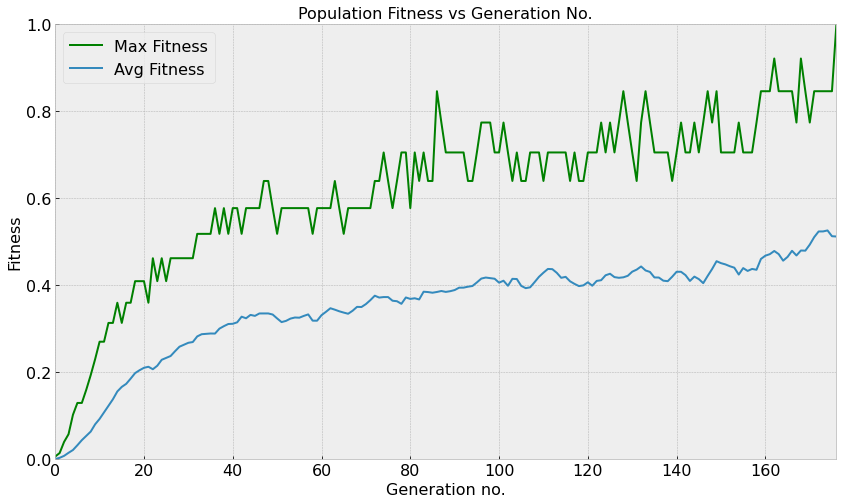

In [37]:
mypop.analyse()